# CA4015 - Assignment 1 – Random Forest and AutoML

This assignment was carried out to better understand how machine learning models are trained using *Sci-kit learn* and the relative ease that this same task can be carried out using AutoML, such as the *PyCaret* library. 

The [Pima Indians diabetes](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?select=diabetes.csv) dataset used for this assignment comes from Kaggle. To summarise the description on Kaggle, the objective of the dataset is to predict whenever a patient has diabetes or not from certain attributes provided in the dataset. All patients are female, over the age of 21 and of Pima Indian heritage.

This assignment will be broken down into the following 4 sections:

### Section 1 - Setup and data preprocessing
- 1.1 - Importing packages
- 1.2 - Reading in the dataset
- 1.3 - Exploring the data
- 1.4 - Relating back to diabetes causes

### Section 2 - Creating a Random Forest
- 2.1 - Splitting data
- 2.2 - Default Random Forest
- 2.3 - Grid Search
- 2.4 - Boosting
- 2.5 - Results and comparison

### Section 3 - Using PyCaret
- 3.1 - Running model generation
- 3.2 - Results

### Section 4 - Conclusion
- 4.1 - Manual model creation vs. AutoML methods
---

#### The GitHub repo for this project can be found [here](https://github.com/teg-lad/CA4015-diabetes-classification)

---

### Section 1.1 - Importing packages

Below is a list of all the packages that I am inporting for this notebook and a short note on the use of said package.

---

*RandomForestClassifier* - The random forest classifier from sci-kit learn.

*AdaBoostClassifier, GradientBoostingClassifier, DecisionTreeClassifier* - Boosting methods and decision tree to create a boosted random forest.

*cross_val_score* - Cross validation to test how generalizable a model is.

*train_test_split* - Split the data into a train and test set.

*GridSearchCV* - Grid search method to find the optimal parameters for a model.

*accuracy_score, confusion_matrix, classification_report* - Some functions for evaluation.

*pandas* - for dataframes and data wrangling.

*scatter_matrix* - For use on the dataframe to get a scatter plot for every pair of attributes.

*pycaret* - AutoML library for finding the ideal model for a machine learning problem.

*mean, std* - To compute the mean and std of the data to find outliers.


In [1]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
from pandas.plotting import scatter_matrix
from pycaret.classification import *
from numpy import mean, std

### Section 1.2 - Reading in the dataset

I'm starting by reading in the dataset from a csv saved locally that I downloaded from the [Kaggle page](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?select=diabetes.csv). This is done using the Pandas read_csv function with a path to the csv as shown below.

I then call the head() method on the dataframe to make sure it has been read in correctly and to get an idea of the columns.

In [2]:
diabetes = pd.read_csv(r"C:\Users\adamt\notebooks\ca4015\diabetes.csv")# Change to the link to download to use directly
columns = diabetes.columns
print(diabetes.head())
print(columns)

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


### Section 1.3 - Exploring the data


With the dataset now loaded it is time to explore the data a little before throwing it at the random forest. To explore the data I am going to make use of some pandas methods to get some different views of the data. These together will hopefully give me a good idea of how values are distributed, correlated and highlight any outliers.

The methods I will use are:

- info()
- describe()
- hist()

---

### dataframe.info()

This method returns a table with the column names of the dataframe as rows along the table. There is a count of non-null values which is useful to quickly spot if any values are nulls. The data type of each column is also listed in the table.



In [6]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


It can be seen from above that we have no null values in the dataset and we have primarily integers and a couple of float columns. This means we don't need to worry about nulls or using a method such as integer or one-hot encoding to deal with categorical data.

### dataframe.describe()

The describe() method gives some high-level statistics of the different attributes such as mean, standard deviation, min and max values, median and quartile values. This can quickly give you an idea of how the data is distributed within the different features in the dataset.

In [7]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Some interesting things I can see from the above:

**Pregnancies**: Quite skewed to the right with a possibility of having some outliers at the right tail.

**Glucose**: Reasonably normal distribution. There seems to be erroneois entries with values of 0. This doesn't make sense to my knowledge and the reasearch I have done. I think it may be best to either correct these with the mean value or possibly even just drop the records if they may confuse the model.

**BloodPressure**: Reasonably normal distribution. This feature is the diatolic blood pressure, which is apparently the least reliable form of blood pressure measurement, the other being mean blood pressure and systolic blood pressure. This to mean seems like it may be an error with the sensor reading the blood pressure.

**SkinThickness**: Quite skewed to the right. This had a minimum of 0 and a max of 99. The former seems like an issue with rounding possibly as there are a lot of values at that low value. The latter is definitely an outlier and possibly an artefact.

**Insulin**: Quite skewed to the right. It seems that there is the possibility of artefacts on both sides of the distribution. It doesn't seem like an insulin level of zero makes sense, so these seem like artefacts. The max value seems to be an outlier.

**BMI**: Reasonably normal distribution. There seems to be BMI values of 0 which make no sense and may need to be addressed.

**DiabetesPedigreeFunction**: Skewed to the right. Seems to be some very high values at the max end, may need to consider these when preprocessing.

**Age**: Skewed to the right. It seems that we have a much greater representation of younger people than of older. This can be seen through the median age of 29 and the upper quartile of 41 with the max age being 81.

---

It can be seen from all of these insights from the describe method that although we don't have null values we may have some artefacts that need to be addressed or at least considered before passing this data to our random forest classifer.

### dataframe.hist()

The hist() method produces a histogram for each of the features in the dataset which shows the distribution of all the values. This can help to highlight any outliers and give a visual representation of the distribution of the feature.

array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

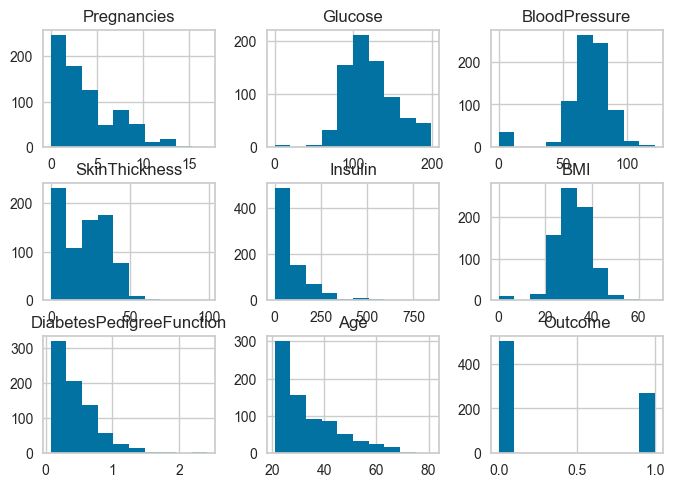

In [8]:
diabetes.hist()

The observations we made using the describe() method are backed up here by the hist method. So now we have to consider if we need to take action against these outliers or artefacts.

Luckily, decision trees are robust against outliers due to the nature of their classification rules. They build these rules to partition the data into the most pure sub-groups possible. This means that the exact value of an attribute isn't important, just whether it is less than or greater than the rule that determines the groupings. This translates well to random forest.

However, it is good practive to inspect the quality of the data, clean and process to ensure we have the data in the right format to ensure the best results. So I will looks specifically at finding and fixing aretefacts within the data. There is no need to consider scaling as the decision trees that random forests consist of will work the same with or without the values normalized.

### Assessing the aretfacts within the data

The approach I am taking here is to take the mean of a feature and the standard deviation. Using this we can find data points that are quite far from the mean. In this case I am choosing 3 standard deviation. This is because with ample data and an assumption that the data is roughly normal, we can assume that roughly 99.7% of the data sits within 3 standard deviations of the mean. Values outside of this will be considered outliers.

For our usecase I am just going to review these values and determine if they appear to be artefacts. If they are I will replace them with the mean of the feature. I could also

In [38]:
for column in diabetes.columns:
    data = diabetes[column].values
    
    # calculate summary statistics
    data_mean, data_std = mean(data), std(data)
    # identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    
    print(column + ":", lower, "- " + str(upper))
    lower = set(diabetes[diabetes[column] < lower].index.tolist())
    upper = set(diabetes[diabetes[column] > upper].index.tolist())
    current = upper.union(lower)
    print(diabetes.iloc[list(current)])
    print("-------------------------------------------------------------")
    

Pregnancies: -6.257098753893652 - 13.94720292056032
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
88            15      136             70             32      110  37.1   
298           14      100             78             25      184  36.6   
455           14      175             62             30        0  33.6   
159           17      163             72             41      114  40.9   

     DiabetesPedigreeFunction  Age  Outcome  
88                      0.153   43        1  
298                     0.412   46        1  
455                     0.212   38        1  
159                     0.817   47        1  
-------------------------------------------------------------
Glucose: 25.039143525391836 - 216.74991897460816
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
342            1        0             68             35        0  32.0   
182            1        0             74             20       23  27.7   
502           

### Splitting data into a train and test set for manual model creation

In [ ]:
x = diabetes.drop("Outcome", axis=1)
y = diabetes.Outcome

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

### Training a default decision tree

In [ ]:
clf = RandomForestClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### Understanding which features correlate with diabetes

The correlation between the different attributes and the otucome can be seen below.

Glucose concentration correlates with diabetes, which makes sense as insulin resistance puts pressure on the pancrease to make more insulin and eventually the demand for insulin can't be met and the glucose levels rise. So we know Glucose is an important feature.

BMI is also an important feature as a persons BMI being higher indicates they are closer to being overweight for their height. People who are not physically active or are overweight or even possibly obese can develop an insulin resistance.

Age is a factor as the older someone gets typically they become less active and develop an insulin resistance. Their pancreas may become less functional with age.

During pregnancy, women can get gestational diabetes due to the changes taking place in their body. This typically goes away after pregancy, but can increase the chance of getting type 2 diabetes later in life.

It seems skin thickness and blood pressure are not overly important attributes and can possibly be dropped.

In [ ]:
diabetes.corr()["Outcome"].sort_values(ascending=False)

array([[<AxesSubplot:xlabel='Pregnancies', ylabel='Pregnancies'>,
        <AxesSubplot:xlabel='Glucose', ylabel='Pregnancies'>,
        <AxesSubplot:xlabel='BloodPressure', ylabel='Pregnancies'>,
        <AxesSubplot:xlabel='SkinThickness', ylabel='Pregnancies'>,
        <AxesSubplot:xlabel='Insulin', ylabel='Pregnancies'>,
        <AxesSubplot:xlabel='BMI', ylabel='Pregnancies'>,
        <AxesSubplot:xlabel='DiabetesPedigreeFunction', ylabel='Pregnancies'>,
        <AxesSubplot:xlabel='Age', ylabel='Pregnancies'>,
        <AxesSubplot:xlabel='Outcome', ylabel='Pregnancies'>],
       [<AxesSubplot:xlabel='Pregnancies', ylabel='Glucose'>,
        <AxesSubplot:xlabel='Glucose', ylabel='Glucose'>,
        <AxesSubplot:xlabel='BloodPressure', ylabel='Glucose'>,
        <AxesSubplot:xlabel='SkinThickness', ylabel='Glucose'>,
        <AxesSubplot:xlabel='Insulin', ylabel='Glucose'>,
        <AxesSubplot:xlabel='BMI', ylabel='Glucose'>,
        <AxesSubplot:xlabel='DiabetesPedigreeFunction', 

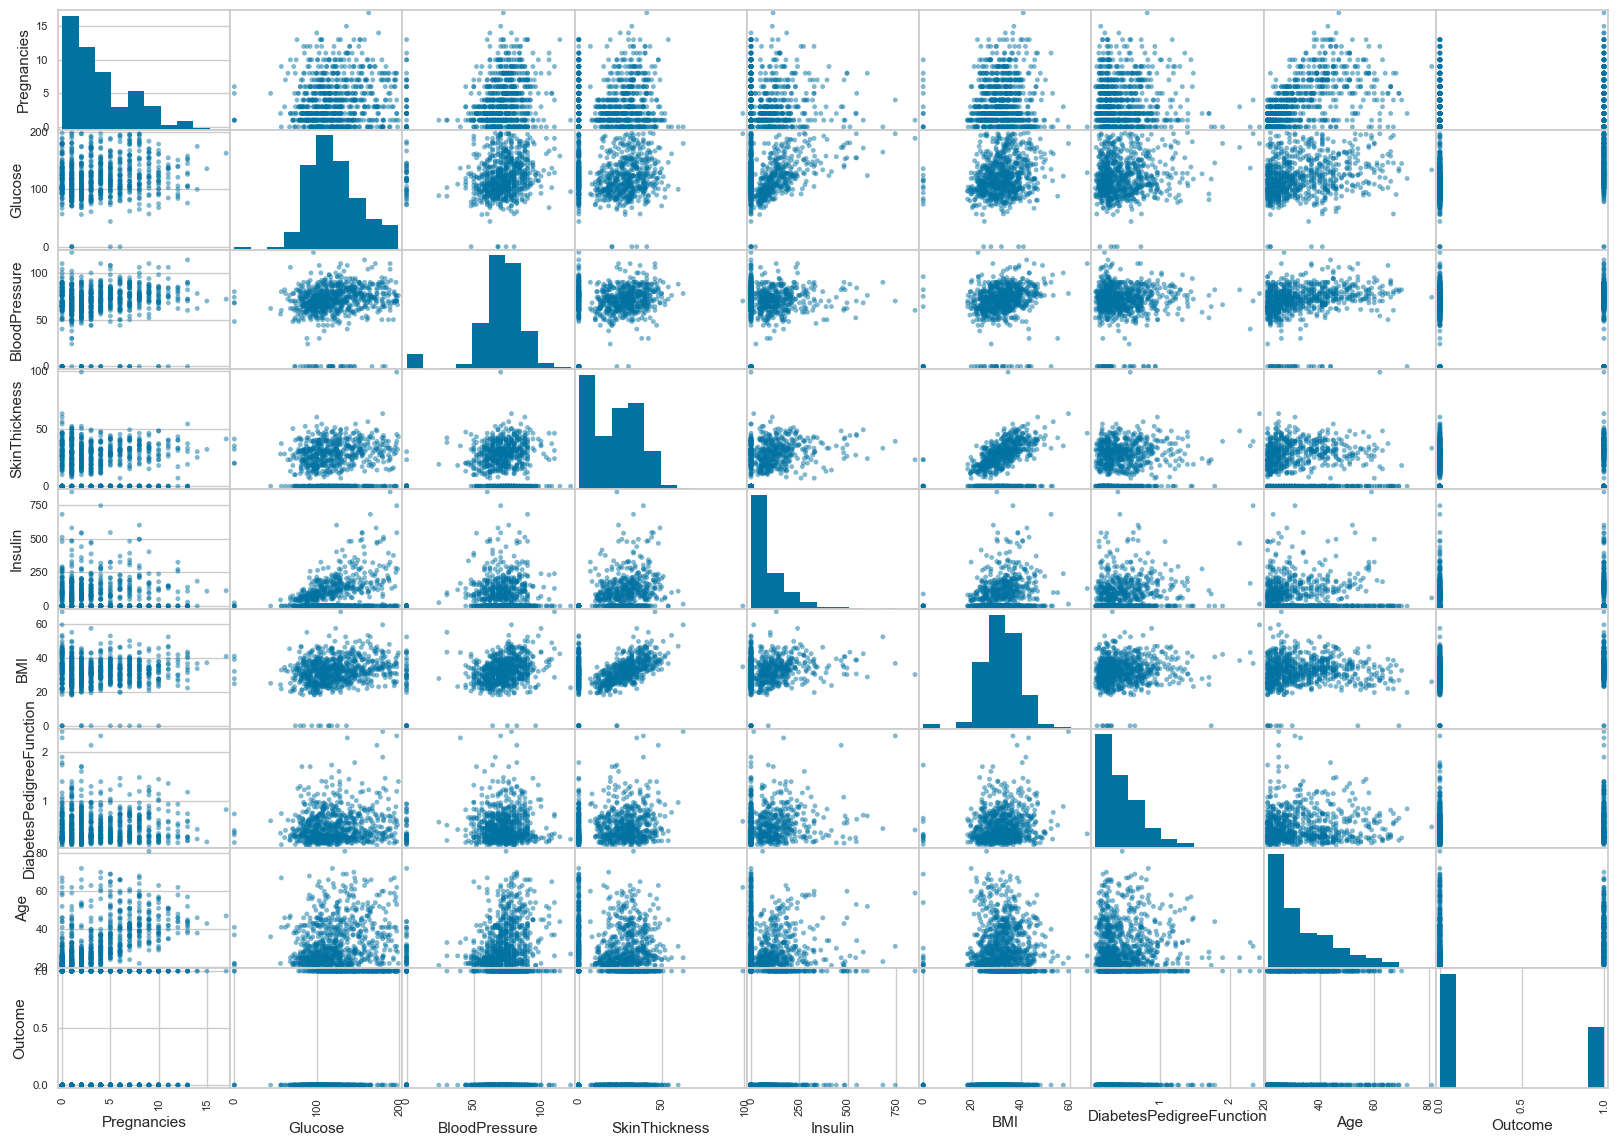

In [39]:
scatter_matrix(diabetes[diabetes.columns], figsize=(20,14))

In [ ]:
diabetes = diabetes.drop(["SkinThickness", "BloodPressure"], axis=1)

In [ ]:
diabetes.columns

### Feature enginerring

Testing out some combinations of the important attributes to see if there is any combination that makes an important attribute.

These new features are not very useful so we will drop them.

In [ ]:
tmp_diabetes = diabetes
tmp_diabetes["pregnancies_per_year"] = tmp_diabetes["Pregnancies"]/tmp_diabetes["Age"]
tmp_diabetes["glucose_per_bmi"] = tmp_diabetes["Glucose"]/tmp_diabetes["BMI"]
tmp_diabetes["bmi_per_age"] = tmp_diabetes["BMI"]/tmp_diabetes["Age"]

In [ ]:
tmp_diabetes.corr()["Outcome"].sort_values(ascending=False)

### Using grid search to pick optimal parameters (For the parameters I'm checking!)

I'm using GridSearch to find the best combination of attributes in the set od parameters I have definited.

From the list I provided it seems that the best combination is 
{'max_depth': 2,
 'max_leaf_nodes': 4,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
x = diabetes.drop("Outcome", axis=1)
y = diabetes.Outcome

scalar = StandardScaler()
scaled_values = scalar.fit_transform(x.values)
x_scaled = pd.DataFrame(scaled_values, index=x.index, columns=x.columns)

X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
params = [{"n_estimators": [100, 200], 
           "max_depth":[1, 2], 
           "min_samples_split": [2, 5, 10], 
           "min_samples_leaf": [1, 3, 5], 
           "max_leaf_nodes": [2, 4, 6], 
           "min_impurity_decrease": [0.0, 0.2, 0.4]}]
clf = RandomForestClassifier(random_state=42)

gs_rf = GridSearchCV(clf, params, scoring="accuracy", cv=5)
gs_rf.fit(X_train, y_train)

In [ ]:
gs_rf.best_params_

In [ ]:
gs_rf

In [ ]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, max_leaf_nodes=4), random_state=42, n_estimators=55, algorithm="SAMME.R", learning_rate=0.1)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
gbc_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=55, criterion='friedman_mse',  max_depth=2, random_state=42, max_leaf_nodes=4)
gbc_clf.fit(X_train, y_train)
y_pred = gbc_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### Feature enginerring

Testing out some combinations of the important attributes to see if there is any combination that makes an important attribute.

These new features are not very useful so we will drop them.

In [51]:
tmp_diabetes = diabetes
tmp_diabetes["pregnancies_per_year"] = tmp_diabetes["Pregnancies"]/tmp_diabetes["Age"]
tmp_diabetes["glucose_per_bmi"] = tmp_diabetes["Glucose"]/tmp_diabetes["BMI"]
tmp_diabetes["bmi_per_age"] = tmp_diabetes["BMI"]/tmp_diabetes["Age"]

In [52]:
tmp_diabetes.corr()["Outcome"].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
glucose_per_bmi             0.170972
pregnancies_per_year        0.163744
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
bmi_per_age                -0.029840
Name: Outcome, dtype: float64

### Using grid search to pick optimal parameters (For the parameters I'm checking!)

I'm using GridSearch to find the best combination of attributes in the set od parameters I have definited.

From the list I provided it seems that the best combination is 
{'max_depth': 2,
 'max_leaf_nodes': 4,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [165]:
x = diabetes.drop("Outcome", axis=1)
y = diabetes.Outcome

scalar = StandardScaler()
scaled_values = scalar.fit_transform(x.values)
x_scaled = pd.DataFrame(scaled_values, index=x.index, columns=x.columns)

X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [166]:
params = [{"n_estimators": [100, 200], 
           "max_depth":[1, 2], 
           "min_samples_split": [2, 5, 10], 
           "min_samples_leaf": [1, 3, 5], 
           "max_leaf_nodes": [2, 4, 6], 
           "min_impurity_decrease": [0.0, 0.2, 0.4]}]
clf = RandomForestClassifier(random_state=42)

gs_rf = GridSearchCV(clf, params, scoring="accuracy", cv=5)
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [167]:
gs_rf.best_params_

{'max_depth': 2,
 'max_leaf_nodes': 4,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
gs_rf

In [177]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, max_leaf_nodes=4), random_state=42, n_estimators=55, algorithm="SAMME.R", learning_rate=0.1)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7597402597402597
[[86 14]
 [23 31]]
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       100
           1       0.69      0.57      0.63        54

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.72       154
weighted avg       0.75      0.76      0.75       154



In [180]:
gbc_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=55, criterion='friedman_mse',  max_depth=2, random_state=42, max_leaf_nodes=4)
gbc_clf.fit(X_train, y_train)
y_pred = gbc_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7337662337662337
[[83 17]
 [24 30]]
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       100
           1       0.64      0.56      0.59        54

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.70       154
weighted avg       0.73      0.73      0.73       154



In [9]:
scores = cross_val_score(clf, x, y, cv=5)
print(scores)

[0.74025974 0.74675325 0.74675325 0.75816993 0.75816993]


In [10]:
scores = cross_val_score(ada_clf, x, y, cv=5)
print(scores)

[0.70779221 0.67532468 0.72077922 0.79738562 0.69934641]


In [13]:
exp_name = setup(diabetes, target="Outcome")

,Description,Value
0,session_id,5919
1,Target,Outcome
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(768, 9)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [14]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7690,0.8050,0.5576,0.6929,0.6132,0.4531,0.4609,0.0410
rf,Random Forest Classifier,0.7690,0.8174,0.5360,0.7121,0.6011,0.4462,0.4616,0.0550
ridge,Ridge Classifier,0.7541,0.0000,0.5076,0.6814,0.5744,0.4091,0.4216,0.0040
lda,Linear Discriminant Analysis,0.7522,0.8002,0.5132,0.6723,0.5755,0.4073,0.4181,0.0050
lightgbm,Light Gradient Boosting Machine,0.7504,0.8220,0.5959,0.6477,0.6134,0.4310,0.4372,0.0110
gbc,Gradient Boosting Classifier,0.7411,0.8131,0.5526,0.6281,0.5828,0.3981,0.4032,0.0270
et,Extra Trees Classifier,0.7337,0.7863,0.4316,0.6563,0.5131,0.3446,0.3621,0.0600
knn,K Neighbors Classifier,0.7298,0.7473,0.5196,0.6187,0.5583,0.3682,0.3750,0.0080
ada,Ada Boost Classifier,0.7262,0.7820,0.5251,0.6145,0.5559,0.3626,0.3720,0.0230
dt,Decision Tree Classifier,0.6962,0.6570,0.5363,0.5575,0.5416,0.3160,0.3196,0.0040
